Start with autoreload magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like util.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import config

import util

In [3]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
surface_files = [
    f"{obspack_dir}/co2_alt_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_brw_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cba_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cgo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_kum_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_ljo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_mlo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_psa_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_smo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_spo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_gould_shipboard-insitu_1_allvalid.nc",
]

obspack_files = {}
for f in surface_files:
    stn = os.path.basename(f).split('_')[1]
    obspack_files[stn] = os.path.basename(f)

### Contribution details
- 18 Obspack netcdf files (e.g. mlo_surface-flask_4_representative.nc) each with all 10 tracers
- including 3 ship files in ObsPack format
- can only output 30,000 values, so:
    - for HIPPO and ATom only every fifth 10-sec value exists
    - for ORCAS, only every other 10-sec value exists
    - for Gould, every fifth value exists
        - sampling is 5 samples every 2.5 min, separated by 1 hr 45 min, so will mostly get 1 sample per 15-min ambient period
- also provided a single text file of all data

In [4]:
droot = "/glade/p/eol/stephens/longcoll/apo-simulation-data/NIES"

path = f"{droot}/{obspack_files['cba']}"
print(path)
ds = xr.open_dataset(path)

tc = ds['time_components']
tc = tc.to_dataframe(dim_order=['calendar_components','obs']).unstack(level=0)
tc.columns = ['year', 'month', 'day', 'hour', 'minute', 'second'] 

droplist = ['time_components','solartime_components','MIP_MDM','MIP_models','assimilation_concerns'] #,'mip_nmodels']
ds = ds.drop(droplist)
df = ds.to_dataframe()

df['time'] = pd.to_datetime(tc)
df = df.set_index('time')
df

# kluge - need to make station name dynamic and allow any number of stations
path = f"{droot}/{obspack_files['psa']}"
print(path)
ds2 = xr.open_dataset(path)

tc2 = ds2['time_components']
tc2 = tc2.to_dataframe(dim_order=['calendar_components','obs']).unstack(level=0)
tc2.columns = ['year', 'month', 'day', 'hour', 'minute', 'second'] 

ds2 = ds2.drop(droplist)
df2 = ds2.to_dataframe()

df2['time'] = pd.to_datetime(tc2)
df2 = df2.set_index('time')
df2

df['apo_jena'].min()

/glade/p/eol/stephens/longcoll/apo-simulation-data/NIES/co2_cba_surface-flask_4_representative.nc
/glade/p/eol/stephens/longcoll/apo-simulation-data/NIES/co2_psa_surface-flask_4_representative.nc


-1.469630024075741e-05

In [86]:
# add derived APO variables

df['apo_cesm'] = util.compute_apo (
    o2=df['o2_cesm'],
    co2=df['co2_cesm'],
    n2=df['n2_cesm']
)

df['apo_diss'] = util.compute_apo (
    o2=df['o2_gk01r16'],
    co2=df['co2_somffn'],
    n2=df['n2_era']
)

df['apo_gridfed'] = util.compute_apo (
    o2=df['o2_gridfed'],
    co2=df['co2_gridfed'],
    n2=0.0
)

df['apo_oco2mip'] = util.compute_apo (
    o2=df['co2_oco2mip'] * -1.4,
    co2=df['co2_oco2mip'],
    n2=0.0
)

# kluge - need to make station name dynamic and allow any number of stations
df2['apo_cesm'] = util.compute_apo (
    o2=df2['o2_cesm'],
    co2=df2['co2_cesm'],
    n2=df2['n2_cesm']
)

df2['apo_diss'] = util.compute_apo (
    o2=df2['o2_gk01r16'],
    co2=df2['co2_somffn'],
    n2=df2['n2_era']
)

df2['apo_gridfed'] = util.compute_apo (
    o2=df2['o2_gridfed'],
    co2=df2['co2_gridfed'],
    n2=0.0
)

df2['apo_oco2mip'] = util.compute_apo (
    o2=df2['co2_oco2mip'] * -1.4,
    co2=df2['co2_oco2mip'],
    n2=0.0
)

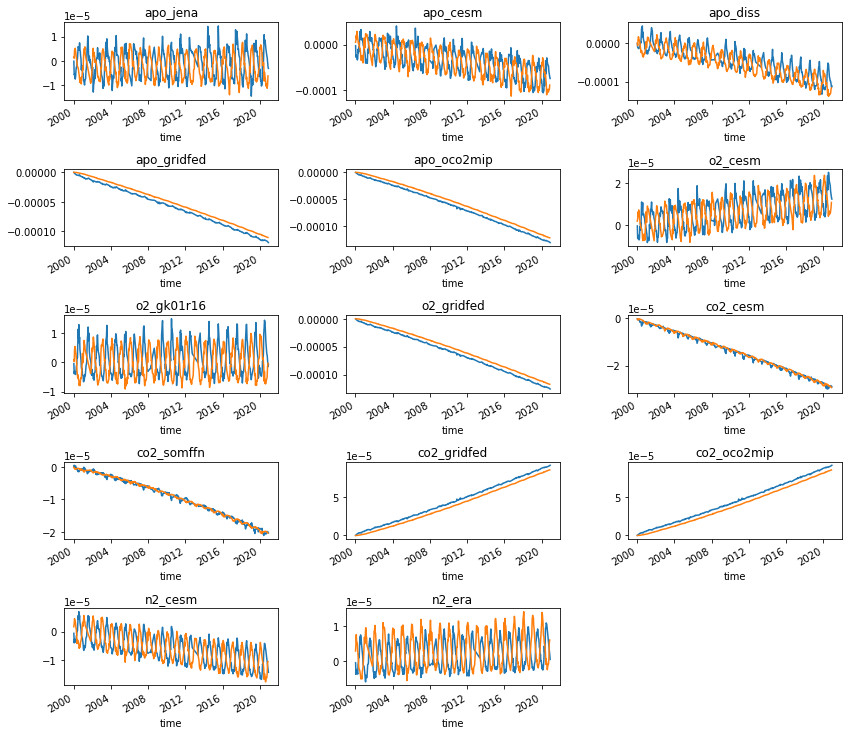

In [87]:
sno_vars = [
    'apo_jena',
    'apo_cesm',
    'apo_diss',
    'apo_gridfed',
    'apo_oco2mip',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
]

n_plots = len(sno_vars)
ncol = int(np.sqrt(n_plots))
nrow = int(((n_plots / ncol) + n_plots % ncol))
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    df[v].plot(ax=ax)
    df2[v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    

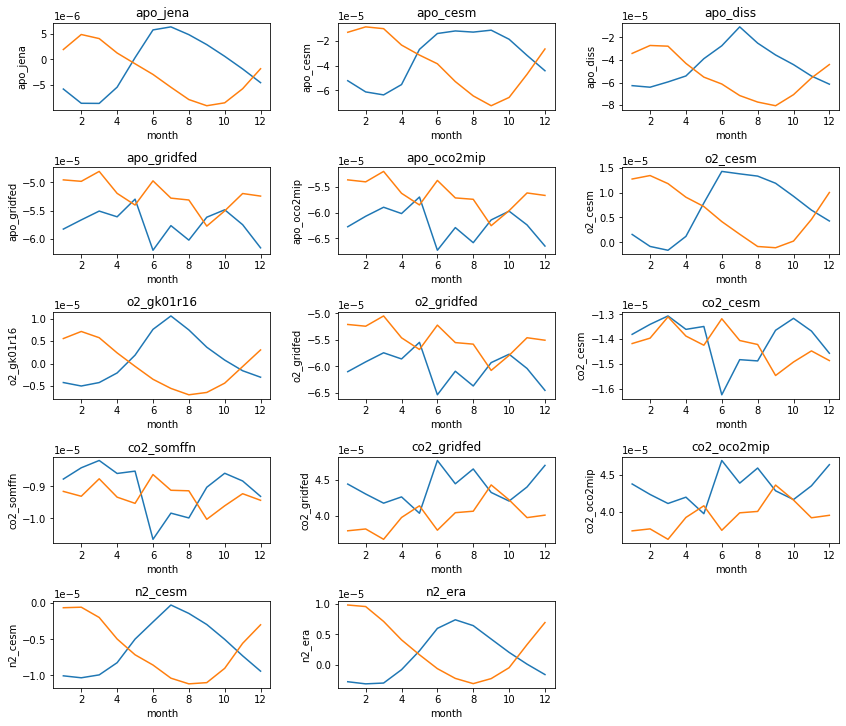

In [88]:
# seasonal climatology
ds = df.to_xarray()
ds_seas=ds.groupby('time.month').mean('time')
ds_seas['apo_cesm']

# kluge - need to make station name dynamic and allow any number of stations
ds2 = df2.to_xarray()
ds2_seas=ds2.groupby('time.month').mean('time')
ds2_seas['apo_cesm']


fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    ds_seas[v].plot(ax=ax)
    ds2_seas[v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    